In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import os, sys
from pathlib import Path
BASE_DIR = Path('.').resolve().parent.parent.parent
os.chdir(BASE_DIR)
from phm08ds.models import experiment

## Load Dataset

In [2]:
folderpath = './phm08ds/data/files/'
data_op_1 = pd.read_csv(folderpath + 'data_op_01.csv')
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state,Operational_condition
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,1,1
14,1,15,9.9988,0.2500,20.0,489.05,604.63,1497.87,1302.51,10.52,...,8124.37,8.6496,0.03,369,2319,100.0,28.84,17.0805,1,1
15,1,16,9.9987,0.2500,20.0,489.05,604.61,1500.47,1311.39,10.52,...,8127.07,8.6609,0.03,369,2319,100.0,28.71,17.1759,1,1
17,1,18,10.0066,0.2507,20.0,489.05,604.23,1502.57,1304.56,10.52,...,8119.39,8.6646,0.03,367,2319,100.0,28.60,17.1096,1,1
35,1,36,10.0024,0.2504,20.0,489.05,604.43,1499.85,1306.89,10.52,...,8121.73,8.6260,0.03,369,2319,100.0,28.52,17.1036,2,1


## Data preprocessing

Get sensors that a I like it better

In [3]:
from phm08ds.features.feature_selection import SelectSensors

tf_select_sensors = SelectSensors(kind='custom', sensors=[3,6,10,14])
data_op_1 = tf_select_sensors.fit_transform(data_op_1)
data_op_1.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_3,Sensor_6,Sensor_10,Sensor_14,Operational_condition,Health_state
0,1,1,10.0047,0.2501,20.0,1309.95,394.88,45.40,8.6216,1,1
14,1,15,9.9988,0.2500,20.0,1302.51,394.93,45.39,8.6496,1,1
15,1,16,9.9987,0.2500,20.0,1311.39,394.44,45.52,8.6609,1,1
17,1,18,10.0066,0.2507,20.0,1304.56,394.31,45.10,8.6646,1,1
35,1,36,10.0024,0.2504,20.0,1306.89,394.36,45.36,8.6260,1,2


Before feeding to the classifier, let's remove unwanted information, such as unit, time_step and operational settings.

In [4]:
from phm08ds.features.feature_selection import RemoveInfo

tf_remove_info = RemoveInfo()

data_with_features = tf_remove_info.fit_transform(data_op_1)
data_with_features.head()

,Sensor_3,Sensor_6,Sensor_10,Sensor_14,Health_state
0,1309.95,394.88,45.40,8.6216,1
14,1302.51,394.93,45.39,8.6496,1
15,1311.39,394.44,45.52,8.6609,1
17,1304.56,394.31,45.10,8.6646,1
35,1306.89,394.36,45.36,8.6260,2


We need to normalize our data. Let's use Z-score standardization.

In [5]:
from sklearn.preprocessing import StandardScaler

tf_std_scaller = preprocessing.StandardScaler()
data_with_features_std = tf_std_scaller.fit_transform(data_with_features.drop(labels='Health_state', axis=1))
data_with_features_std

array([[-0.16893857,  0.85477079, -0.38167972, -1.17034624],
       [-1.06544604,  0.93149834, -0.42173461, -0.42029381],
       [ 0.00457901,  0.17956834,  0.09897901, -0.11759408],
       ...,
       [ 1.64094613, -2.29105881,  1.26057091,  2.10309687],
       [ 1.8867627 , -1.58516534,  1.9415041 ,  0.5708469 ],
       [ 1.865073  , -1.66189289,  2.26194325,  1.52448499]])

In [6]:
labels_op_1 = np.array(data_with_features['Health_state'])
labels_op_1

array([1, 1, 1, ..., 4, 4, 4])

# Classification steps

## How to use Elman network of neurolab

Folllowing the example at https://pythonhosted.org/neurolab/ex_newelm.html

In [8]:
import neurolab as nl

In [10]:
min_list = []
max_list = []

for feature in range(0,data_with_features_std.shape[1]):
    min_list.append(data_with_features_std[:,feature].min())
    max_list.append(data_with_features_std[:,feature].max())
    
min_max_list = list(map(list, list(zip(min_list, max_list))))
min_max_list

[[-2.6246942400416367, 3.671342749288904],
 [-3.4112810594247662, 2.8343416060539304],
 [-2.4645341718333627, 3.6238096247779246],
 [-3.104410013209671, 3.5656991091889427]]

In [11]:
from sklearn.preprocessing import LabelBinarizer

target_tf = LabelBinarizer(neg_label=-1)
labels_encoded = target_tf.fit_transform(labels_op_1)

In [12]:
elman_clf = nl.net.newelm(min_max_list, [50,4], [nl.trans.TanSig(), nl.trans.TanSig()])

In [13]:
# Set initialized functions and init
elman_clf.layers[0].initf = nl.init.InitRand([-0.1, 0.1], 'wb')
elman_clf.layers[1].initf= nl.init.InitRand([-0.1, 0.1], 'wb')
elman_clf.init()

In [14]:
# Train network
error = elman_clf.train(data_with_features_std, labels_encoded, epochs=500, goal=0.01, adapt=True, show=101)
# Simulate network
output = elman_clf.sim(data_with_features_std)

Epoch: 101; Error: 1.6684103458297006;
Epoch: 202; Error: 1.6684103458297006;
Epoch: 303; Error: 1.6684103458297006;
Epoch: 404; Error: 1.6684103458297006;
The maximum number of train epochs is reached


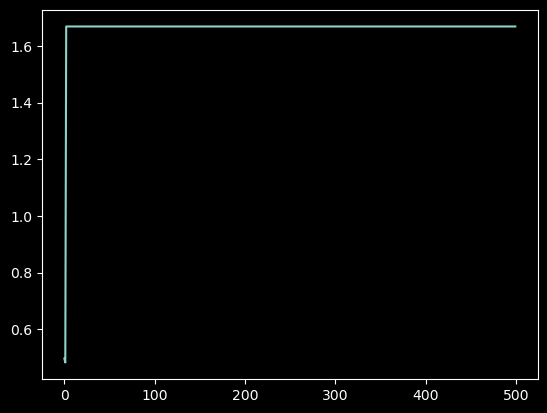

In [15]:
plt.plot(error)

### Test the newtwork

In [16]:
real_targets = target_tf.inverse_transform(labels_encoded)

In [17]:
predicted_targets = target_tf.inverse_transform(output)

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [19]:
accuracy_score(real_targets, predicted_targets)

0.1967451322290032

In [20]:
confusion_matrix(real_targets, predicted_targets)

array([[   0,  728,    0,    0],
       [   0, 1354,    0,    0],
       [   0, 3228,    0,    0],
       [   0, 1572,    0,    0]])